# Generating Synthetic Data with SMOTE - LSOA Atlas Data

David Pugh, July 2018

Investigating the use of SMOTE and ADASYN to generate synthetic data based on an existing dataset.
Data set is at https://files.datapress.com/london/dataset/lsoa-atlas/lsoa-data.csv

In [37]:
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
from scipy import stats

print(__doc__)
%matplotlib inline

Automatically created module for IPython interactive environment


In [38]:
RANDOM_STATE = 32

### Create Dataset

In [39]:
original_df = pd.read_csv("https://files.datapress.com/london/dataset/lsoa-atlas/lsoa-data.csv", encoding='unicode_escape', low_memory=False)
original_df.head()

,Lower Super Output Area,Names,Mid-year Population Estimates;All Ages;2001,Mid-year Population Estimates;All Ages;2002,Mid-year Population Estimates;All Ages;2003,Mid-year Population Estimates;All Ages;2004,Mid-year Population Estimates;All Ages;2005,Mid-year Population Estimates;All Ages;2006,Mid-year Population Estimates;All Ages;2007,Mid-year Population Estimates;All Ages;2008,...,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total
0,E01000907,Camden 001A,1519.0,1538.0,1528.0,1547.0,1593.0,1492.0,1455.0,1457.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E01000908,Camden 001B,1547.0,1577.0,1605.0,1637.0,1629.0,1598.0,1605.0,1526.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,E01000909,Camden 001C,1600.0,1598.0,1618.0,1634.0,1610.0,1635.0,1615.0,1584.0,...,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,3.0
3,E01000912,Camden 001D,1738.0,1728.0,1678.0,1707.0,1710.0,1669.0,1645.0,1618.0,...,9.0,9.0,0.0,1.0,10.0,11.0,0.0,0.0,7.0,7.0
4,E01000913,Camden 001E,1617.0,1676.0,1662.0,1714.0,1705.0,1690.0,1716.0,1657.0,...,8.0,11.0,0.0,1.0,6.0,7.0,0.0,1.0,13.0,14.0


Now create a dataset with 2:1 ratio


In [40]:
print("\nNumeric Only")
#original_df = original_df._get_numeric_data()
original_df = original_df.iloc[:,2:15]

# get rid of NaNs
original_df = original_df.apply(lambda x: pd.Series(x.dropna().values))

# check for NaNs
pd.isnull(original_df).sum() > 0
original_df.head()

n_features = len(original_df.columns)

original_df.columns = list(range(0,n_features))
original_df['target'] = 0
print(original_df.head())
print(original_df.groupby('target').count())

cols=list(range(0,n_features))
#create a df with 2x orginal data with target =0
original_2_df = original_df.append(original_df)

#Add teh original again but with target = 1
original_df['target'] = 1
original_2_df = original_2_df.append(original_df)
print(original_2_df.info())

print(original_2_df.groupby('target').count())

# you want all rows, and the feature_cols' columns
X = original_2_df.iloc[:, :-1].values
y = original_2_df['target'].values


Numeric Only
        0       1       2       3       4       5       6       7       8  \
0  1519.0  1538.0  1528.0  1547.0  1593.0  1492.0  1455.0  1457.0  1421.0   
1  1547.0  1577.0  1605.0  1637.0  1629.0  1598.0  1605.0  1526.0  1528.0   
2  1600.0  1598.0  1618.0  1634.0  1610.0  1635.0  1615.0  1584.0  1560.0   
3  1738.0  1728.0  1678.0  1707.0  1710.0  1669.0  1645.0  1618.0  1593.0   
4  1617.0  1676.0  1662.0  1714.0  1705.0  1690.0  1716.0  1657.0  1663.0   

        9      10      11      12  target  
0  1410.0  1431.0  1457.0  1466.0       0  
1  1497.0  1564.0  1605.0  1647.0       0  
2  1593.0  1602.0  1594.0  1642.0       0  
3  1542.0  1589.0  1625.0  1653.0       0  
4  1709.0  1695.0  1776.0  1827.0       0  
          0     1     2     3     4     5     6     7     8     9     10  \
target                                                                     
0       4835  4835  4835  4835  4835  4835  4835  4835  4835  4835  4835   

          11    12  
target   

### Create Samplers

In [41]:
samplers = [
    ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['SMOTE - Reg', SMOTE(kind='regular', random_state=RANDOM_STATE)],
    ['SMOTE - B1', SMOTE(kind='borderline1', random_state=RANDOM_STATE)],
    ['SMOTE - B2', SMOTE(kind='borderline2', random_state=RANDOM_STATE)],
    #['SMOTE - SVM', SMOTE(kind='svm', random_state=RANDOM_STATE)]
]

###  Define function to plot correlation matrix

In [42]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

def half_correlation_matrix(df, title, file=""):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10,10))
    corr_plot = sns.heatmap(df, square=True, cmap= cmap, vmax=0.5, vmin=-0.5, mask=mask,  center=0, linewidths=.5, cbar_kws={"shrink": .5}).set_title(title)
    
    if file != "":
        fig = corr_plot.get_figure()
        fig.savefig(file +'.png', bbox_inches='tight')

In [43]:
def correlation_matrix(df, title, file=""):
    plt.figure(figsize=(10,10))
    corr_plot = sns.heatmap(df, annot=True, square=True, cmap='coolwarm', vmax=1, vmin=-1).set_title(title)
    
    if file != "":
        fig = corr_plot.get_figure()
        fig.savefig(file+'.png', bbox_inches='tight')

In [44]:
def bhatta ( hist1,  hist2):
  '''Calculates the Byattacharyya distance of two histograms.'''

  def normalize(h):
    return h / np.sum(h)

  return 1 - np.sum(np.sqrt(np.multiply(normalize(hist1), normalize(hist2))))

In [45]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist2))
    return intersection

### Define function to resample data and compare with original

In [46]:
def resample_and_compare(X,y,sampler, folder, txt_fontsize=7):
    #Create a resampled data set 
    X_res, y_res = sampler[1].fit_sample(X,y)
    resampled_df = pd.DataFrame(X_res)
    resampled_df['target'] = y_res
    
    #Merge resampled and original data, then drop duplicates
    merged_df = pd.concat([original_df, resampled_df])
    #these are the new resampled datapoints
    generated_df = merged_df.drop_duplicates(keep=False).reset_index(drop=True)
    #print(generated_df.info())
    
    generated_df['sampler'] = sampler[0]
    #correlate each original dataset minoroty classes with the new resampled one
    print("\n------------------------------------------------------------------------\n")
    print("----------- " + sampler[0])
    
    #plt.figure()
    figfile = folder + '/orig_and_gen_data_'+ sampler[0]
    f, axes = plt.subplots(n_features, figsize=(8,25))
    """f.subplots_adjust(left=0.125, 
                        bottom=0.1, 
                        right=0.9, 
                        top=2.0,
                        wspace=0.2, 
                        hspace=0.2)"""
    
    axes[0].set_title("Original and Generated Data using " + sampler[0], fontsize="x-large")
        
    pearsonrs=[]
    intersections=[]
    bhatts=[]
    method =[]
    
    for i in cols:
        s = sns.distplot(generated_df[i], hist=False, rug=False, label="G-"+ str(i), ax=axes[i], 
                     kde_kws={'linestyle':'-', 'linewidth':3})
        sns.distplot(original_df[i], hist=False, rug=False, label="O-"+ str(i), ax=axes[i], 
                     kde_kws={'linestyle':'--', 'linewidth':2})
        
        
        o_hist, _ = np.histogram(original_df[i], bins=100)
        g_hist, _ = np.histogram(generated_df[i], bins=100)
        bhatt = bhatta(o_hist, g_hist)  
        intersection = return_intersection(o_hist, g_hist)
        pearson = stats.pearsonr(o_hist,g_hist)
                
        pearsonrs.append(pearson[0])
        bhatts.append(bhatt)
        intersections.append(intersection)
        method.append(sampler[0])
        
        print("Intersection for {}: {:03.2f} ".format(i ,intersection ))
        #axes[i].text(0.15, 0.85,'Intersection:{} '.format(intersection), fontsize=9) #add text
        s.text(0.02, 0.90,'Pearson Coeff:', 
                     fontsize=txt_fontsize,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.90,'{:05.3f}'.format(pearson[0]), 
                     fontsize=txt_fontsize,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        
        s.text(0.02, 0.80,'Intersection:', 
                     fontsize=txt_fontsize,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.80,'{:05.3f}'.format(intersection), 
                     fontsize=txt_fontsize,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)       
        
        s.text(0.02, 0.70,'Bhattacharyya Dist:', fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.70,'{:05.3f}'.format(bhatt), 
                     fontsize=txt_fontsize,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        
    f.savefig(figfile+'.png', bbox_inches='tight')
    
    #print("Original Data")
    #print(original_df.head())
    original_corr = original_df.iloc[:, :-1].corr()
    
    #print("Generated Data")
    #print(generated_df.head())    
    gen_corr = generated_df.iloc[:, :-2].corr()
    
    print("\nCorrelation Matrix - {}".format(sampler[0]))
    correlation_matrix(gen_corr, 'Generated Data '+ sampler[0])
    
    print("Correlation Matrix Diff - {}".format(sampler[0]))
    correlation_matrix(original_corr - gen_corr, 'Correlation Difference ' + sampler[0], folder + '/corr_diff_data_'+ sampler[0])
    half_correlation_matrix(original_corr - gen_corr, 'Correlation Difference ' + sampler[0], folder + '/half_corr_diff_data_'+ sampler[0])
    
    summary_df = pd.DataFrame( data = {'method': method,
                                       'feature': cols, 
                                       'pearsonr': pearsonrs, 
                                       'intersection': intersections,
                                       'bhattacharyya': bhatts})

    summary_df.to_csv(folder + '/summary_stats_'+ sampler[0], index=False)

### Correlation plot of the original data

     0    1    2    3    4    5    6    7    8    9    10   11   12
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


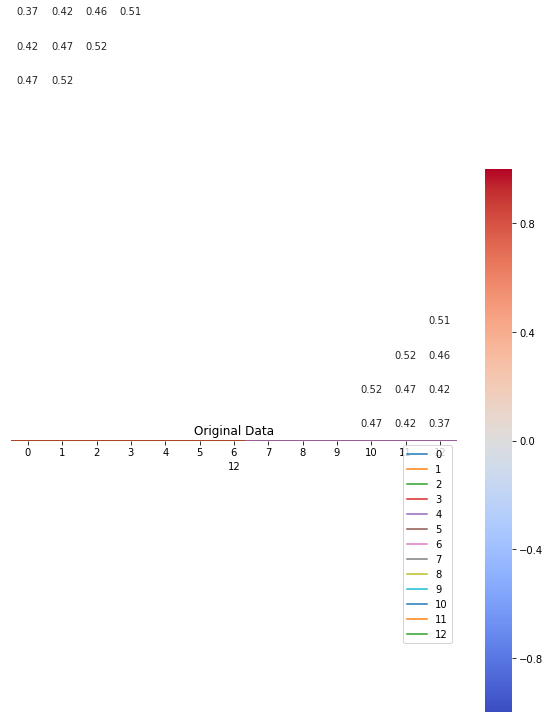

In [47]:
orignal_corr  = original_df.iloc[:, :-1].corr()
print(orignal_corr - orignal_corr )
correlation_matrix(orignal_corr, 'Original Data')

for i in cols:
    sns.distplot(original_df[i], hist=False, rug=False, label=i)
    plt.legend()


In [48]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Generate synthetic data for each sampler type and compare correlation matrix to original data


------------------------------------------------------------------------

----------- ADASYN
Intersection for 0: 0.03 
Intersection for 1: 0.03 
Intersection for 2: 0.03 
Intersection for 3: 0.03 
Intersection for 4: 0.05 
Intersection for 5: 0.11 
Intersection for 6: 0.20 
Intersection for 7: 0.29 
Intersection for 8: 0.28 
Intersection for 9: 0.47 
Intersection for 10: 0.65 
Intersection for 11: 0.61 
Intersection for 12: 0.51 

Correlation Matrix - ADASYN
Correlation Matrix Diff - ADASYN

------------------------------------------------------------------------

----------- SMOTE - Reg
Intersection for 0: 0.03 
Intersection for 1: 0.03 
Intersection for 2: 0.03 
Intersection for 3: 0.03 
Intersection for 4: 0.04 
Intersection for 5: 0.10 
Intersection for 6: 0.25 
Intersection for 7: 0.37 
Intersection for 8: 0.33 
Intersection for 9: 0.44 
Intersection for 10: 0.61 
Intersection for 11: 0.57 
Intersection for 12: 0.50 

Correlation Matrix - SMOTE - Reg
Correlation Matrix Diff - SMO

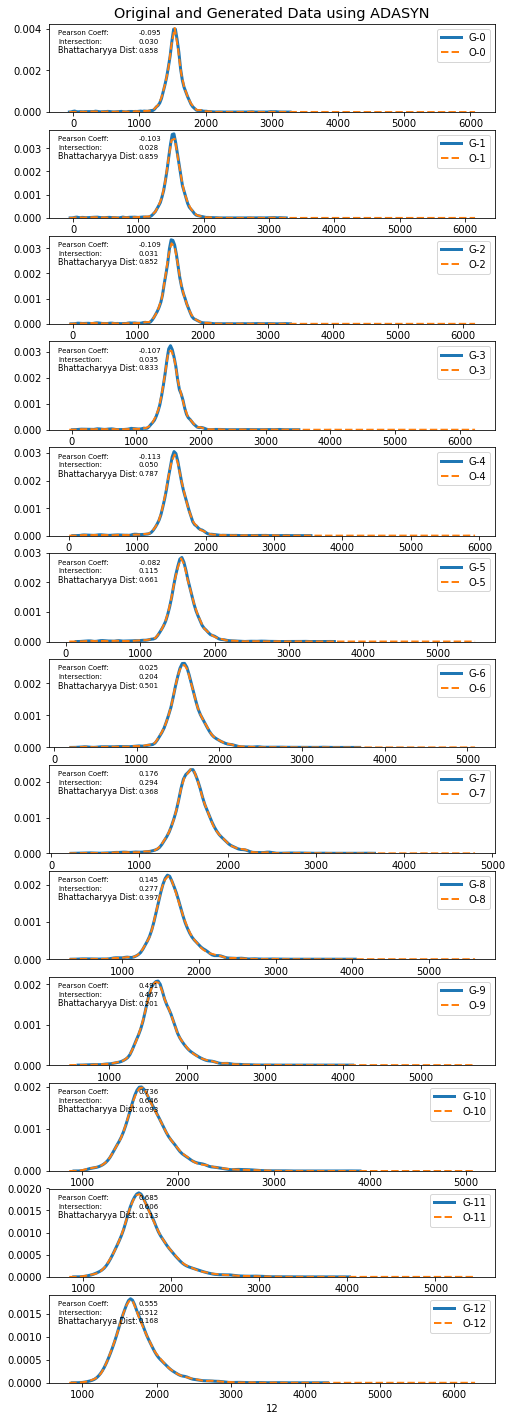

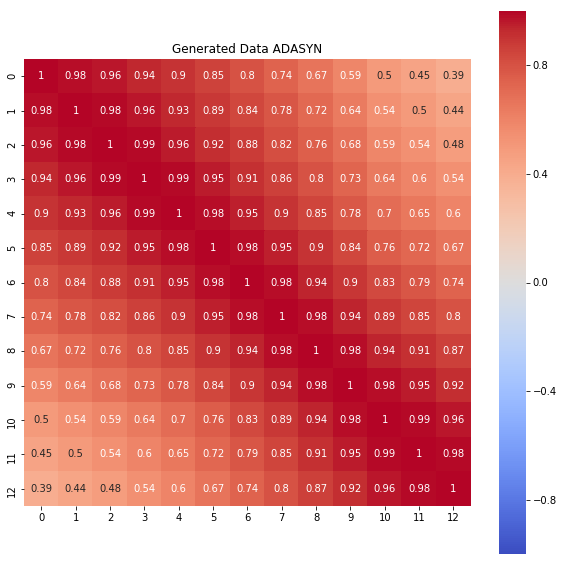

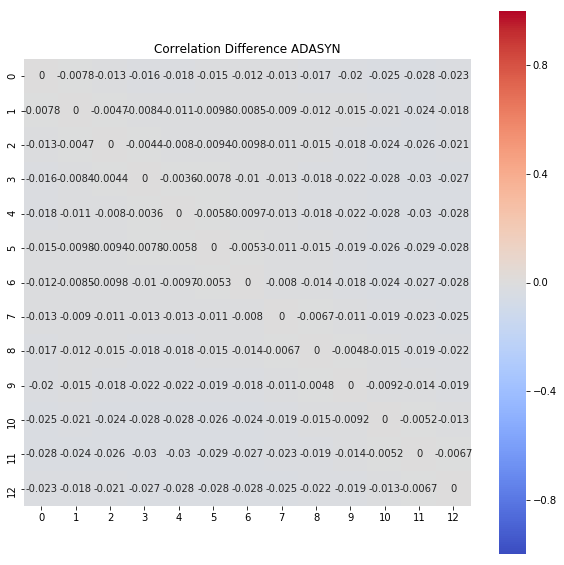

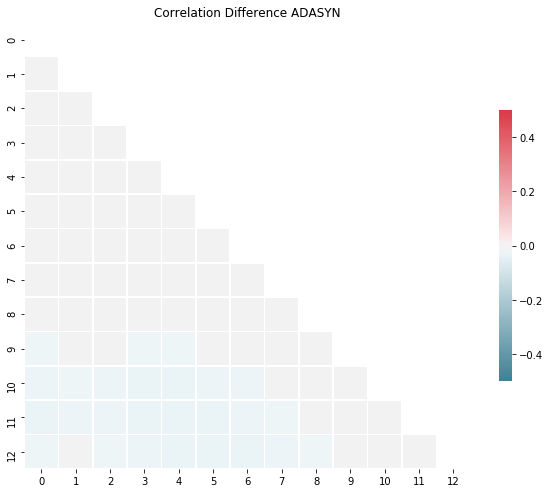

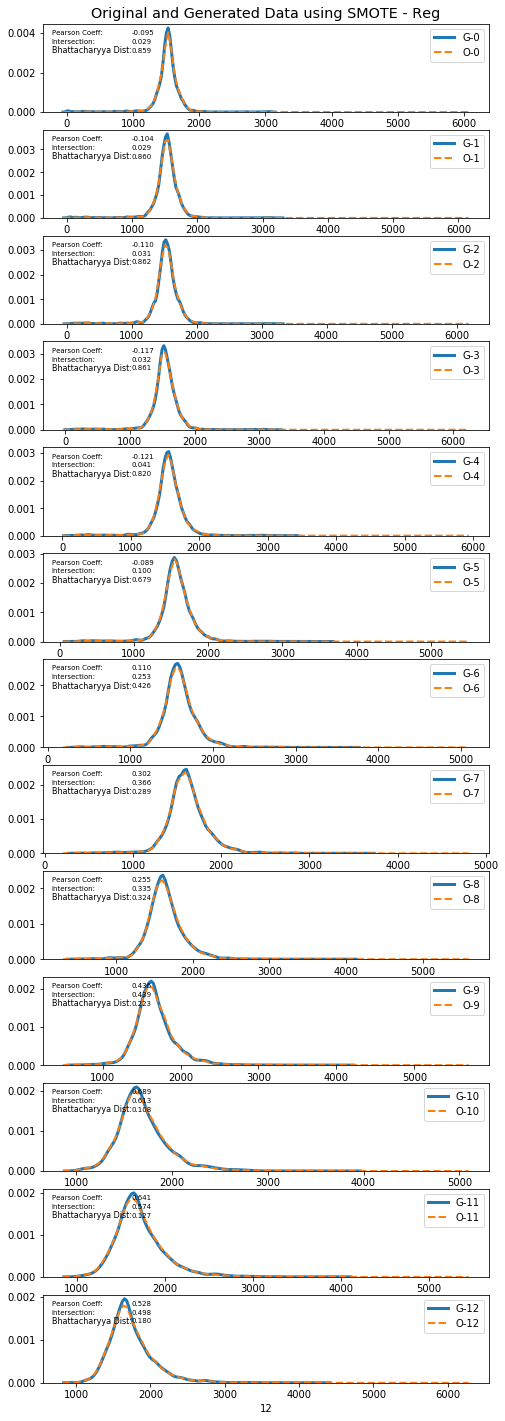

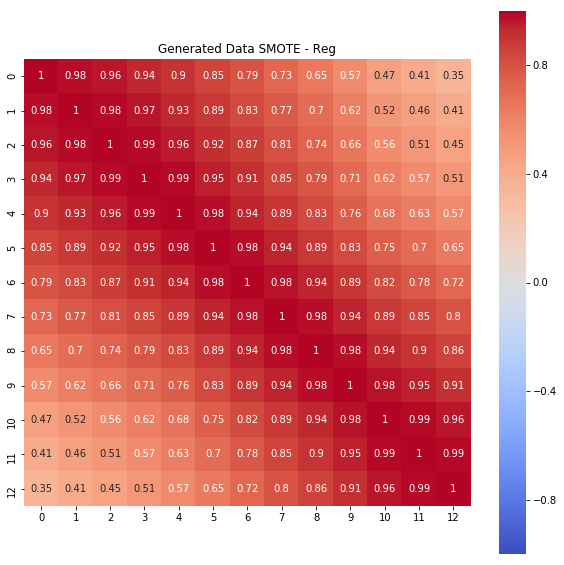

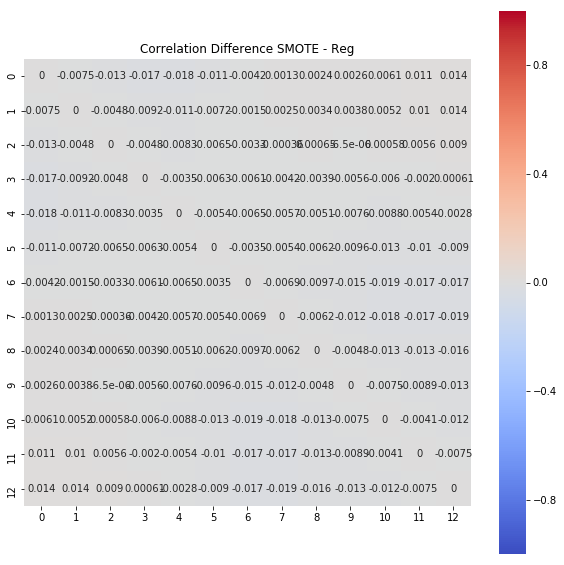

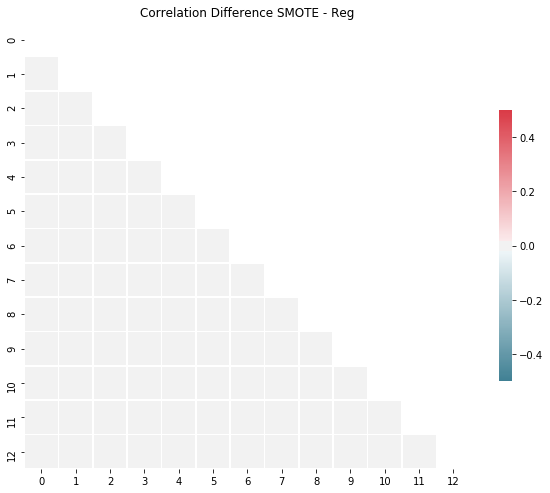

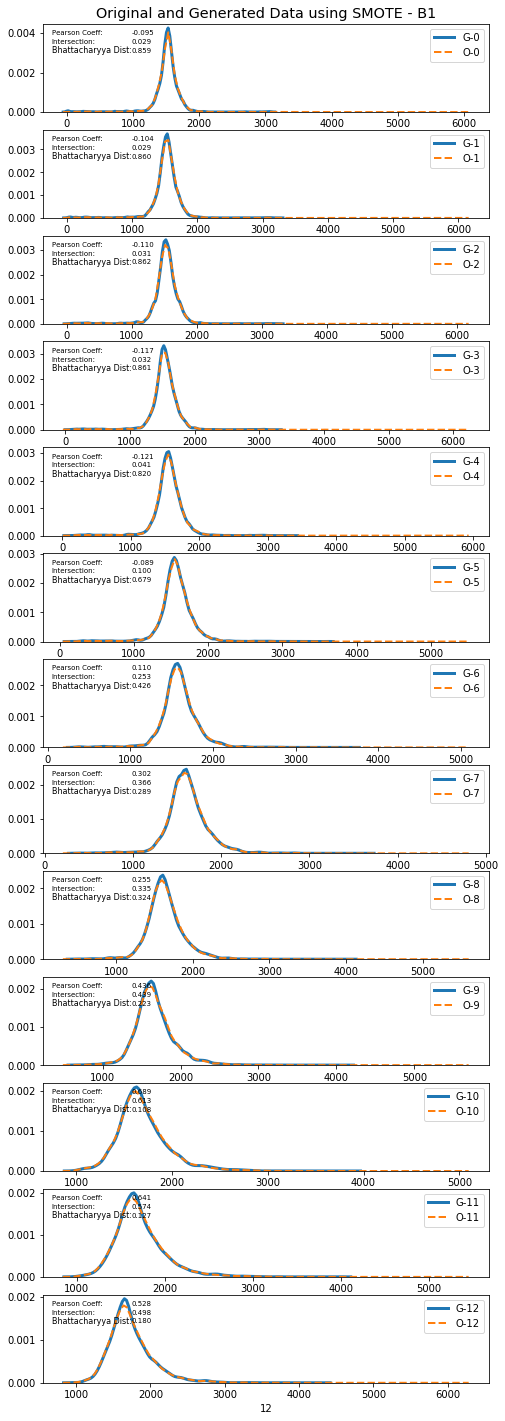

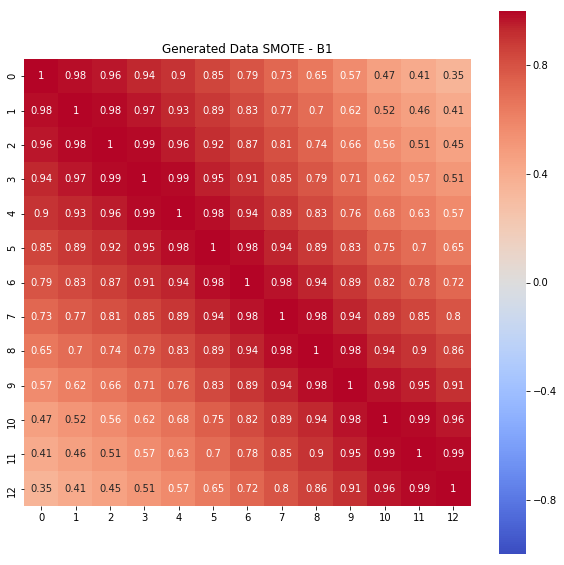

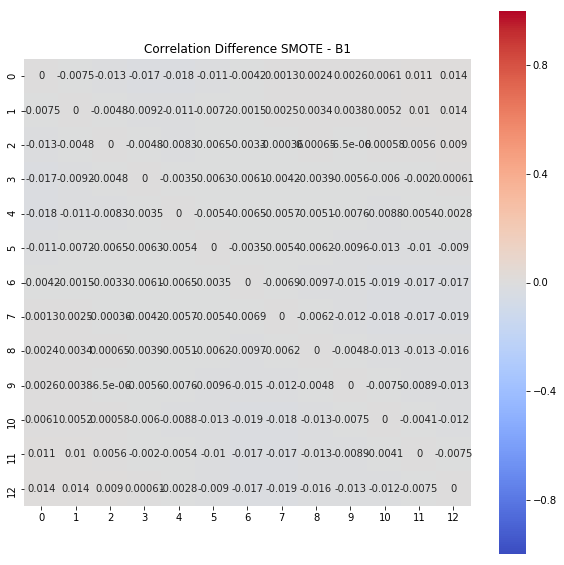

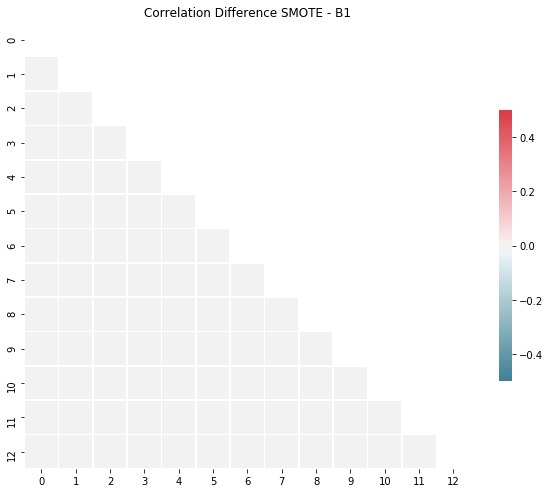

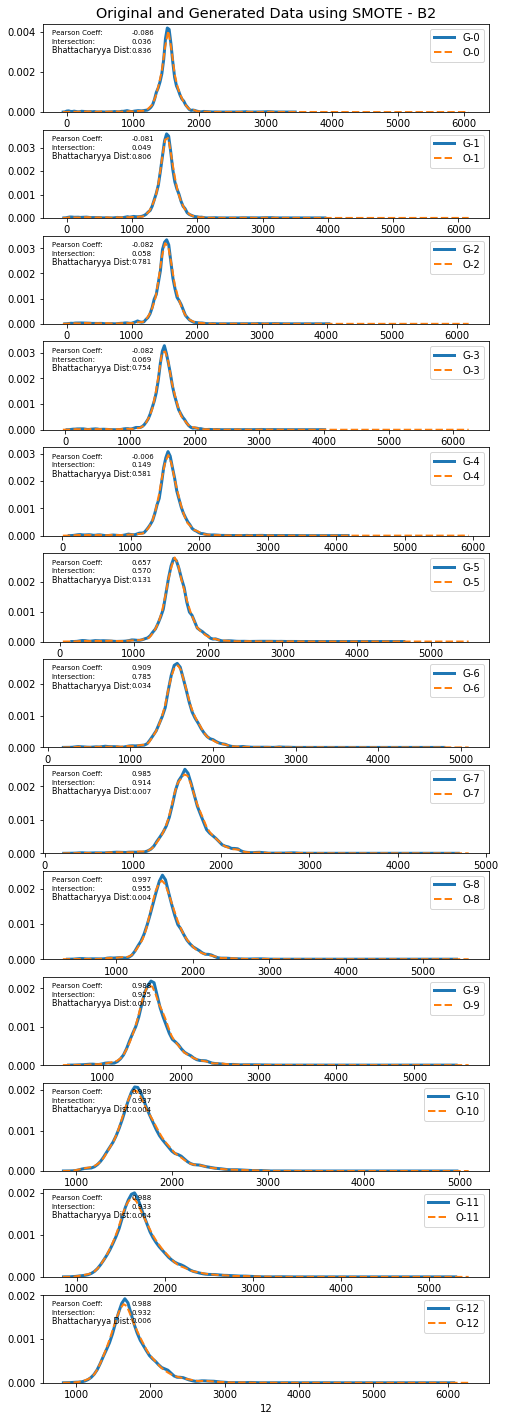

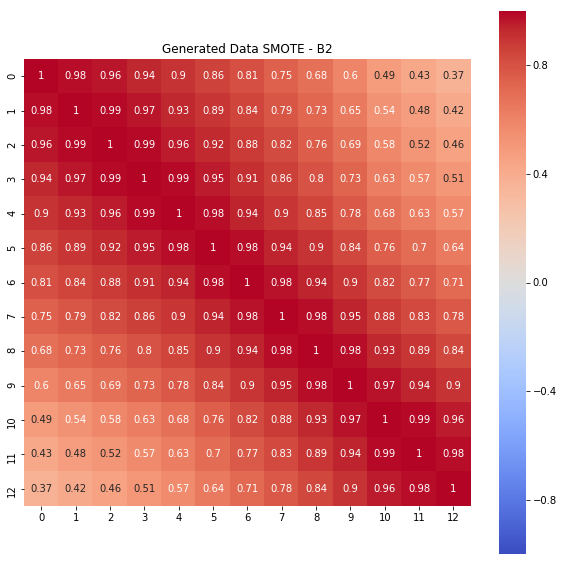

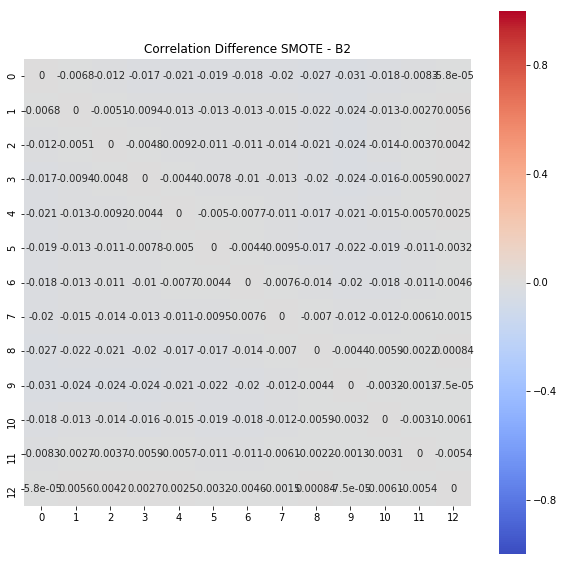

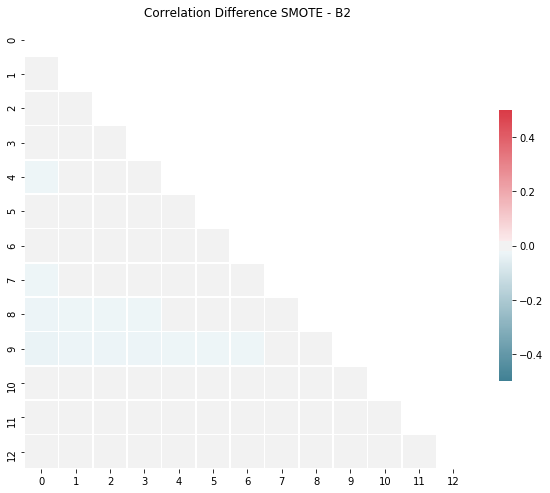

In [49]:
for sampler in samplers:
    resample_and_compare(X,y,sampler,'smote_lsoa_data')

### 